## Part A

In [ ]:
!pip install webdriver_manager

In [ ]:
# If first time on this machine, uncomment:
# !pip install -q selenium webdriver-manager bs4

import os, re, csv, time, random, json, sys
from typing import List, Tuple, Dict, Optional

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException, WebDriverException, JavascriptException, InvalidSessionIdException
from webdriver_manager.chrome import ChromeDriverManager

# ---------- constants
OUTPUT_FILE = "beer_reviews.csv"
HEADERS = ["beer_name", "review_text", "rating_score"]
PAUSE_LOW, PAUSE_HIGH = 0.6, 1.3
START_URL = "https://www.beeradvocate.com/beer/top-rated/"

# ---------- session management (auto-rebuild on disconnect)
def build_browser() -> webdriver.Chrome:
    profile_path = os.path.expanduser("~/beeradvocate_profile")
    os.makedirs(profile_path, exist_ok=True)

    chrome_opts = webdriver.ChromeOptions()
    chrome_opts.add_argument(f"--user-data-dir={profile_path}")
    chrome_opts.add_argument("--profile-directory=Default")
    chrome_opts.page_load_strategy = "eager"
    chrome_opts.add_experimental_option("excludeSwitches", ["enable-automation"])
    chrome_opts.add_experimental_option("useAutomationExtension", False)
    chrome_opts.add_argument("--disable-blink-features=AutomationControlled")
    # keep these for stability; harmless on desktop
    chrome_opts.add_argument("--no-sandbox")
    chrome_opts.add_argument("--disable-dev-shm-usage")

    # light content prefs
    prefs = {
        "profile.managed_default_content_settings.images": 2,
        "profile.managed_default_content_settings.fonts": 2,
        "profile.managed_default_content_settings.stylesheets": 1,
        "profile.managed_default_content_settings.plugins": 2,
        "profile.managed_default_content_settings.popups": 2,
        "profile.managed_default_content_settings.geolocation": 2,
        "profile.managed_default_content_settings.notifications": 2,
    }
    chrome_opts.add_experimental_option("prefs", prefs)

    service = Service(ChromeDriverManager().install())

    try:
        # in case an old one exists in the notebook
        browser.quit()  # type: ignore[name-defined]
    except:
        pass

    b = webdriver.Chrome(service=service, options=chrome_opts)
    b.set_page_load_timeout(60)

    # mask webdriver flag (guarded)
    try:
        b.execute_cdp_cmd(
            "Page.addScriptToEvaluateOnNewDocument",
            {"source": "Object.defineProperty(navigator, 'webdriver', {get: () => undefined})"}
        )
    except Exception as e:
        print(f"   >> Skipped CDP mask: {e}")

    # block heavy resources (guarded)
    try:
        b.execute_cdp_cmd("Network.enable", {})
        b.execute_cdp_cmd(
            "Network.setBlockedURLs",
            {"urls": [
                "*.png","*.jpg","*.jpeg","*.gif","*.webp","*.svg",
                "*.mp4","*.webm","*.avi","*.mov","*.m4v",
                "*.woff","*.woff2","*.ttf","*.otf"
            ]}
        )
    except Exception as e:
        print(f"   >> Skipped CDP block: {e}")

    return b

def browser_alive(b: webdriver.Chrome) -> bool:
    try:
        _ = b.current_url  # ping
        return True
    except Exception:
        return False

def with_browser(f):
    # decorator: rebuilds browser on InvalidSessionId / DevTools disconnect
    def inner(*args, **kwargs):
        global browser   # <- change from nonlocal to global
        try:
            return f(*args, **kwargs)
        except (InvalidSessionIdException, WebDriverException) as e:
            msg = str(e).lower()
            if "invalid session id" in msg or "disconnected" in msg or "not connected to devtools" in msg:
                print("   >> Lost Chrome session; restarting driver…")
                browser = build_browser()
                try:
                    browser.get(START_URL)
                except Exception:
                    pass
                return f(*args, **kwargs)
            raise
    return inner

# ---------- tiny utils
def pause_briefly():
    time.sleep(random.uniform(PAUSE_LOW, PAUSE_HIGH))

def to_soup(html: str) -> BeautifulSoup:
    return BeautifulSoup(html, "html.parser")

_word_check = re.compile(r"[A-Za-z]{2,}")
def valid_review(txt: str) -> bool:
    if not txt:
        return False
    txt = re.sub(r"\b\d+(?:\.\d+)?\s*/\s*5\b", " ", txt, flags=re.I)
    txt = re.sub(r"\boverall\s*[:\-]?\s*\d+(?:\.\d+)?\b", " ", txt, flags=re.I)
    txt = re.sub(r"\brating\s*[:\-]?\s*\d+(?:\.\d+)?\b", " ", txt, flags=re.I)
    txt = re.sub(r"\s+", " ", txt).strip()
    words = txt.split()
    letters = sum(ch.isalpha() for ch in txt)
    return (len(words) >= 8) and (letters >= 30) and bool(_word_check.search(txt))

@with_browser
def fetch_fast(b, url: str, timeout: int = 10, retries: int = 2) -> Optional[str]:
    script = """
    const url = arguments[0];
    const done = arguments[1];
    fetch(url, {credentials: 'include', cache: 'no-store'})
      .then(r => r.text())
      .then(t => done({ok:true, html:t}))
      .catch(e => done({ok:false, err:String(e)}));
    """
    for _ in range(retries + 1):
        try:
            b.set_script_timeout(timeout)
            res = b.execute_async_script(script, url)
            if res and res.get("ok"):
                return res["html"]
        except TimeoutException:
            return None
        except JavascriptException:
            pass
        pause_briefly()
    return None

@with_browser
def safe_nav(b, url: str, timeout: int = 20, retries: int = 1) -> bool:
    for attempt in range(retries + 1):
        try:
            b.set_page_load_timeout(timeout)
            b.get(url)
            return True
        except TimeoutException:
            print(f"   >> Timeout: {url} (try {attempt+1})")
        except WebDriverException as e:
            print(f"   >> WebDriver: {e}")
        pause_briefly()
    return False

@with_browser
def harvest_beer_links(b, limit: int) -> List[Tuple[str, str]]:
    def normalize(href: str) -> Optional[str]:
        m = re.search(r"/beer/profile/(\d+)/(\d+)/", href or "")
        return f"/beer/profile/{m.group(1)}/{m.group(2)}/" if m else None

    collected = set()
    prev, idle = 0, 0

    for _ in range(60):
        links = b.find_elements(By.CSS_SELECTOR, "a[href*='/beer/profile/']")
        for l in links:
            try:
                href = l.get_attribute("href") or ""
                nm = (l.text or "").strip()
                canon = normalize(href)
                if canon and nm:
                    collected.add((nm, canon))
            except:
                continue

        count = len(collected)
        if count == prev:
            idle += 1
        else:
            idle = 0
            prev = count

        if idle >= 3 or count >= limit:
            break

        b.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(0.85)

    result = sorted(collected, key=lambda x: (x[0].lower(), x[1]))
    print(f"Collected {len(result)} beers; using {min(limit, len(result))}.")
    return result[:limit]

def build_review_url(path: str, offset: int) -> str:
    return f"https://www.beeradvocate.com{path}?view=beer&start={offset}"

def extract_reviews(html: str) -> List[Tuple[str, float]]:
    soup = to_soup(html)
    results = []
    blocks = soup.select(".review, .user-comment, .user-comment__body, .review-container, .ba-review")
    if not blocks:
        blocks = soup.find_all(["article","div"], attrs={"class": re.compile(r"(review|comment)", re.I)})

    rating_re = re.compile(r"(\d+(?:\.\d+)?)[ ]*/[ ]*5")
    alt_rating = re.compile(r"rating[: ]+(\d+(?:\.\d+)?)", re.I)

    for b in blocks:
        text = re.sub(r"\s+"," ", b.get_text(" ", strip=True)).strip()
        if not valid_review(text):
            continue
        m = rating_re.search(text) or alt_rating.search(text)
        if not m:
            continue
        try:
            score = float(m.group(1))
        except:
            continue
        results.append((text, score))
    return results

def save_rows(file: str, rows: List[Dict[str,str]]):
    new_file = not os.path.exists(file)
    with open(file, "a", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=HEADERS)
        if new_file:
            w.writeheader()
        w.writerows(rows)

# ---------- main loop with recovery
def scrape_reviews(
    beer_limit: int = 250,
    review_goal: int = 12000,
    beer_goal: int = 250,
    pages_each_round: int = 2,
    max_loops: int = 10,
):
    global browser
    if (not browser_alive(browser)) or ("beer/top-rated" not in (browser.current_url or "")):
        print("Opening Top Rated…")
        if not safe_nav(browser, START_URL, timeout=25, retries=2):
            raise RuntimeError("Could not load Top Rated. Log in in this window, then rerun.")

    beers = harvest_beer_links(browser, beer_limit)
    if not beers:
        raise RuntimeError("No beers found. Scroll the page to load content, then rerun.")

    random.shuffle(beers)

    total = 0
    covered: set[str] = set()
    done: Dict[str,bool] = {path: False for _, path in beers}

    for round_idx in range(max_loops):
        print(f"\n--- Cycle {round_idx+1}/{max_loops} ---")
        progress = False

        for beer_nm, beer_path in beers:
            if done[beer_path]:
                continue

            no_hits = 0
            for pg in range(pages_each_round):
                offset = (round_idx * pages_each_round + pg) * 25
                url = build_review_url(beer_path, offset)

                # try fast; then navigate; if session died, decorator rebuilds
                html = fetch_fast(browser, url, timeout=9, retries=1)
                if html is None:
                    if not safe_nav(browser, url, timeout=18, retries=1):
                        print(f"   [{beer_nm}] timeout @ start={offset}")
                        no_hits += 1
                        continue
                    time.sleep(0.9)
                    html = browser.page_source

                found = extract_reviews(html)

                if not found:
                    no_hits += 1
                    if no_hits >= 2:
                        done[beer_path] = True
                        break
                    pause_briefly()
                    continue

                rows = [{"beer_name": beer_nm,
                         "review_text": txt,
                         "rating_score": f"{sc:.2f}"} for txt, sc in found]
                save_rows(OUTPUT_FILE, rows)
                total += len(rows)
                covered.add(beer_nm)
                progress = True
                no_hits = 0
                print(f"   [{beer_nm}] offset={offset}  +{len(rows)}  total={total}  beers={len(covered)}")
                pause_briefly()

                if total >= review_goal and len(covered) >= beer_goal:
                    print(f"\nReached target: {total} reviews from {len(covered)} beers. Finished.")
                    return total

            if no_hits >= 2:
                done[beer_path] = True

        if not progress:
            print("No new data this cycle. Stopping.")
            break

    print(f"\nFinished with {total} reviews across {len(covered)} beers.")
    return total

# ---------- boot + hint
browser = build_browser()
try:
    browser.get(START_URL)
except Exception as e:
    print(f"   >> Could not open start URL yet: {e}")
print(
    "Browser is on Top Rated. If not logged in, open "
    "'https://www.beeradvocate.com/community/login/' in this tab, sign in, "
    "return to Top Rated, then run scrape_reviews()."
)

# run:
scrape_reviews(
    beer_limit=250,
    review_goal=12000,
    beer_goal=250,
    pages_each_round=2,
    max_loops=12
)


Browser is on Top Rated. If not logged in, open 'https://www.beeradvocate.com/community/login/' in this tab, sign in, return to Top Rated, then run scrape_reviews().
Collected 250 beers; using 250.

--- Cycle 1/12 ---
   [Barrel-Aged Sump Coffee Stout] offset=0  +7  total=7  beers=1
   [Barrel-Aged Sump Coffee Stout] offset=25  +7  total=14  beers=1
   [Double Dry Hopped Melcher Street] offset=0  +8  total=22  beers=2
   [Double Dry Hopped Melcher Street] offset=25  +8  total=30  beers=2
   [Speedway Stout - Vietnamese Coffee - Rye Whiskey Barrel-Aged] offset=0  +6  total=36  beers=3
   [Speedway Stout - Vietnamese Coffee - Rye Whiskey Barrel-Aged] offset=25  +6  total=42  beers=3
   [Mornin' Delight] offset=0  +5  total=47  beers=4
   [Mornin' Delight] offset=25  +5  total=52  beers=4
   [Fundamental Forces] offset=0  +3  total=55  beers=5
   [Fundamental Forces] offset=25  +3  total=58  beers=5
   [Darkness] offset=0  +8  total=66  beers=6
   [Darkness] offset=25  +8  total=74  beers

## Task B

In [ ]:
!pip install vaderSentiment
!pip install openpyxl
!pip install spacy
!python -m spacy download en_core_web_sm


#### 1. Load and Clean Data

In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from nltk import ngrams
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from scipy import stats
from collections import Counter, defaultdict
import spacy
from sklearn.preprocessing import MinMaxScaler
nlp = spacy.load("en_core_web_sm")


# --- Load Data ---
# Replace with your scraped data file from Subgroup 1
# Must have columns: product_name, product_review, user_rating
df = pd.read_csv("beer_reviews.csv")

# Drop missing/empty reviews
# df = df.dropna(subset=['Beer_review']).reset_index(drop=True)


# 10k rows from scraped data
df = df.head(10000)


df = df.rename(columns={
    'review_text': 'Beer_review',
    'beer_name': 'Beer_name'
})


print(df.head())

                 Beer_name                                        Beer_review  \
0  Wide Awake It's Morning  Rated by moysauce from Illinois 4.41 /5 rDev -...   
1  Wide Awake It's Morning  Reviewed by StJamesGate from New York 4.05 /5 ...   
2  Wide Awake It's Morning  Reviewed by Rug from Massachusetts 4.32 /5 rDe...   
3  Wide Awake It's Morning  Rated by moysauce from Illinois 4.41 /5 rDev -...   
4  Wide Awake It's Morning  Reviewed by StJamesGate from New York 4.05 /5 ...   

   rating_score  
0          4.41  
1          4.05  
2          4.32  
3          4.41  
4          4.05  


#### 2. Zipf's Law Check

Theta estimate: -1.0087
Standard error: 0.0002
t-statistic: -36.98
p-value: 0


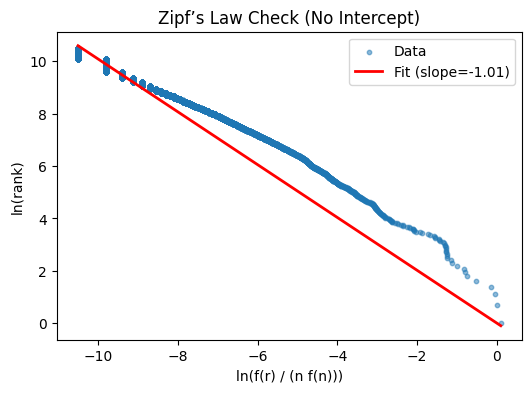

In [ ]:
# --- Build rank-frequency table from beer reviews ---
word_counts = pd.Series(" ".join(df['Beer_review'].astype(str)).lower().split()).value_counts()
ranks = np.arange(1, len(word_counts)+1)   # rank = 1, 2, ..., n
freqs = word_counts.values                 # f(r)

# Alternative formulation variables
n = len(word_counts)                       # number of unique words
f_n = freqs[-1]                            # frequency of lowest-ranked word

z = np.log(freqs / (n * f_n))              # predictor (ln(f(r)/(n f(n))))
y = np.log(ranks)                          # response (ln r)

# --- OLS Regression with NO intercept ---
model_alt = sm.OLS(y, z).fit()
theta = model_alt.params[0]
se_theta = model_alt.bse[0]

# t-test: H0: theta = -1
t_stat = (theta - (-1)) / se_theta
p_val  = 2*(1 - stats.t.cdf(np.abs(t_stat), df=len(y)-1))

print(f"Theta estimate: {theta:.4f}")
print(f"Standard error: {se_theta:.4f}")
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_val:.4g}")

# --- Plot: Zipf’s Law log-log check ---
plt.figure(figsize=(6,4))
plt.scatter(z, y, s=10, alpha=0.5, label="Data")
plt.plot(z, theta*z, color="red", linewidth=2, label=f"Fit (slope={theta:.2f})")
plt.xlabel("ln(f(r) / (n f(n)))")
plt.ylabel("ln(rank)")
plt.title("Zipf’s Law Check (No Intercept)")
plt.legend()
plt.show()



#### 3. Attribute Extraction (N-grams)


In [ ]:
# Load spaCy English model (make sure you have run: python -m spacy download en_core_web_sm)
nlp = spacy.load("en_core_web_sm")

# --------------------------
# 1. Clean review text
# --------------------------
def clean_text_for_attributes(text):
    text = text.lower()
    text = re.sub(r'\d+(\.\d+)?', '', text)         # remove numbers like 4.5, 2022
    text = re.sub(r'[^\w\s]', '', text)             # remove punctuation
    return text

# --------------------------
# 2. Extract candidate attributes with POS tagging
# --------------------------
def extract_attributes(texts, top=30):
    pairs = []
    for doc in nlp.pipe(texts, disable=["ner", "parser"]):
        for i in range(len(doc)-1):
            token1, token2 = doc[i], doc[i+1]
            # Adjective + Noun (e.g. "fruity aroma")
            if token1.pos_ == "ADJ" and token2.pos_ == "NOUN":
                pairs.append(f"{token1.lemma_} {token2.lemma_}")
            # Noun + Noun (e.g. "citrus hops", "chocolate malt")
            if token1.pos_ == "NOUN" and token2.pos_ == "NOUN":
                pairs.append(f"{token1.lemma_} {token2.lemma_}")
    return Counter(pairs).most_common(top)

# --------------------------
# 3. Lift analysis to confirm attributes
# --------------------------
def lift_analysis(texts, terms):
    term_counts = defaultdict(int)
    pair_counts = defaultdict(int)
    total_docs = len(texts)

    for text in texts:
        doc_terms = set(text.lower().split())
        for term in terms:
            w1, w2 = term.split()
            if w1 in doc_terms and w2 in doc_terms:
                pair_counts[term] += 1
        for word in doc_terms:
            term_counts[word] += 1

    lifts = {}
    for term in terms:
        w1, w2 = term.split()
        p_xy = pair_counts[term] / total_docs
        p_x = term_counts[w1] / total_docs
        p_y = term_counts[w2] / total_docs
        if p_x * p_y > 0:
            lifts[term] = p_xy / (p_x * p_y)
    return sorted(lifts.items(), key=lambda x: x[1], reverse=True)

# --------------------------
# Example Run
# --------------------------
# Clean the reviews
cleaned_reviews = [clean_text_for_attributes(t) for t in df['Beer_review'].astype(str)]

# Top descriptive attributes (frequency)
attributes = extract_attributes(cleaned_reviews, top=30)

# Convert to table
attr_df = pd.DataFrame(attributes, columns=["Attribute", "Frequency"])
print("\nTop Descriptive Attributes:")
print(attr_df.to_string(index=False))

# Lift analysis
top_terms = [attr[0] for attr in attributes]
lifts = lift_analysis(cleaned_reviews, top_terms)

# Convert to table
lift_df = pd.DataFrame(lifts, columns=["Attribute", "Lift"])
print("\nLift Values for Top Attributes:")
print(lift_df.to_string(index=False))




Top Descriptive Attributes:
           Attribute  Frequency
          white head       1121
      dark chocolate        714
          dark fruit        685
      tropical fruit        643
        roasted malt        628
         medium body        520
         brown sugar        513
      bourbon barrel        362
           full body        344
           good beer        339
         maple syrup        327
          brown head        325
      imperial stout        310
      milk chocolate        290
         stone fruit        272
moderate carbonation        269
      flavor profile        267
          little bit        259
          great beer        246
            back end        231
     low carbonation        225
         black color        221
          dry finish        217
  medium carbonation        214
      head retention        204
          pint glass        201
         world class        190
          dark brown        176
        roast coffee        171
          t

#### 4. Normalize Frequency and Lift to get 3 desired attributes

In [ ]:
# Put frequency and lift into a DataFrame
attr_df = pd.DataFrame(attributes, columns=["Attribute", "Frequency"])
lift_df = pd.DataFrame(lifts, columns=["Attribute", "Lift"])

# Merge both tables
merged = pd.merge(attr_df, lift_df, on="Attribute", how="inner")

# Normalize Frequency and Lift
scaler = MinMaxScaler()
merged[["Freq_norm", "Lift_norm"]] = scaler.fit_transform(merged[["Frequency", "Lift"]])

# Weighted score: balance frequency & lift
merged["Score"] = 0.5 * merged["Freq_norm"] + 0.5 * merged["Lift_norm"]

# Sort by final score
ranked_attrs = merged.sort_values("Score", ascending=False).reset_index(drop=True)

# --- NEW: filter out irrelevant terms ---
# meaningless pairings for describing beers
exclude_terms = ["tree house", "world class", "white head", "great beer", "good beer"]
filtered_attrs = ranked_attrs[~ranked_attrs["Attribute"].isin(exclude_terms)]

# Show top meaningful descriptors
print("\nFiltered Top Attributes (Meaningful):")
print(filtered_attrs.head(10))


Filtered Top Attributes (Meaningful):
         Attribute  Frequency       Lift  Freq_norm  Lift_norm     Score
3   dark chocolate        714   2.556695   0.572029   0.048304  0.310167
4   tropical fruit        643   3.231471   0.497371   0.070476  0.283923
5     roasted malt        628   3.303219   0.481598   0.072833  0.277216
6       dark fruit        685   1.352539   0.541535   0.008739  0.275137
7      maple syrup        327  11.084380   0.165089   0.328502  0.246796
8      brown sugar        513   4.900603   0.360673   0.125319  0.242996
9      medium body        520   2.395342   0.368034   0.043003  0.205518
10  imperial stout        310   4.845616   0.147213   0.123512  0.135363
11  bourbon barrel        362   2.808708   0.201893   0.056585  0.129239
12     stone fruit        272   4.655672   0.107256   0.117271  0.112263


#### 5. Bag-of-Words (TF-IDF) + Cosine Similarity

In [ ]:
# Build TF-IDF matrix
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['Beer_review'])

# Example customer query: 3 desired attributes
# REPLACE WITH SCRAPED DATA ATTRIBUTES
customer_attributes = ["dark chocolate", "tropical fruit", "roasted malt"]

# Create query vector
query_vec = vectorizer.transform([" ".join(customer_attributes)])

# Cosine similarity between query and all reviews
cosine_scores = cosine_similarity(query_vec, tfidf_matrix).flatten()
df['cosine_similarity'] = cosine_scores


#### 6. Sentiment Analysis


In [ ]:
analyzer = SentimentIntensityAnalyzer()
df['sentiment'] = df['Beer_review'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])

# Normalize sentiment to [0,1]
df['sentiment_norm'] = (df['sentiment'] - df['sentiment'].min()) / (df['sentiment'].max() - df['sentiment'].min())

# Final weighted score
df['combined_score'] = df['cosine_similarity'] * df['sentiment_norm']


##### Method — Bag-of-Words Recommender with Cosine Similarity and Sentiment

1. **Cleaning the reviews**
   We started with the raw BeerAdvocate data, which includes product names, user ratings, and free-text reviews. Before doing anything else, we cleaned the text by removing numbers, punctuation, and boilerplate so we could focus on the words people actually use to describe beer.

2. **Finding meaningful attributes**
   Instead of guessing attributes, we pulled them directly from the reviews using part-of-speech patterns (adjective–noun and noun–noun pairs). From this, we ran a frequency analysis and lift analysis. The final three attributes we selected were **dark chocolate**, **tropical fruit**, and **roasted malt** because they are frequent enough to appear across many reviews and distinctive enough to matter (high lift), while also being meaningful descriptors of beer flavor and aroma.

3. **Turning text into numbers with TF-IDF**
   We represented each review as a vector using a TF-IDF bag-of-words model. This highlights words that are distinctive for a review while down-weighting common ones like “beer” or “good.” We also built a query vector by combining the three attributes the customer specified: **dark chocolate, tropical fruit, roasted malt**.

4. **Measuring how well reviews match the query**
   We calculated cosine similarity between every review and the attribute query vector. This gave us a measure of how closely each review matches the desired attributes. Since each beer has multiple reviews, we averaged the similarity scores at the beer level.

5. **Making sure reviews are positive**
   Just because a review mentions “dark chocolate” doesn’t mean it’s positive—it could be something like “overpowering dark chocolate.” To handle this, we ran sentiment analysis on every review using VADER and normalized the scores between 0 and 1. We then combined similarity and sentiment by multiplying them. This ensures that only beers that mention the chosen attributes **and** are reviewed positively rise to the top.

6. **Ranking and recommending**
   Finally, we averaged the combined scores across reviews for each beer and ranked all beers from highest to lowest. To provide extra evidence, we also reported lift scores to show how strongly the chosen attributes co-occur in beer reviews compared to chance. The top three beers from this ranking are our recommendations.

#### 6. Aggregate to Beer-Level & Create Lift Table

In [ ]:
# Aggregate at beer level, include review count
beer_scores = df.groupby('Beer_name').agg({
    'cosine_similarity': 'mean',
    'sentiment_norm': 'mean',
    'combined_score': 'mean',
    'Beer_review': 'count'   # counts how many reviews per beer
}).reset_index()

# Rename column for clarity
beer_scores = beer_scores.rename(columns={'Beer_review': 'review_count'})

# Rank by final score
beer_scores = beer_scores.sort_values('combined_score', ascending=False)
beer_scores['rank'] = np.arange(1, len(beer_scores)+1)

# Compute lift vs dataset average
avg_score = beer_scores['combined_score'].mean()
beer_scores['lift_vs_avg'] = beer_scores['combined_score'] / avg_score

# Top 20 with clear lift + review count
top20 = beer_scores[['rank','Beer_name','review_count',
                     'cosine_similarity','sentiment_norm',
                     'combined_score','lift_vs_avg']].head(20)

print(top20.to_string(index=False))

 rank                                                Beer_name  review_count  cosine_similarity  sentiment_norm  combined_score  lift_vs_avg
    1                    All That Is And All That Ever Will Be            38           0.096766        0.907303        0.088811     2.758013
    2                                              Triple Shot            31           0.090729        0.899530        0.084623     2.627945
    3                                              Double Shot            31           0.090146        0.921423        0.083365     2.588882
    4                                         Black Note Stout            61           0.093404        0.868187        0.083211     2.584099
    5   Somewhere, Something Incredible Is Waiting To Be Known            22           0.089649        0.821741        0.079015     2.453787
    6                                          Caffè Americano            47           0.082657        0.897114        0.077489     2.406403
    7        

With the attributes dark chocolate, tropical fruit, and roasted malt as input, our recommender ranked beers by cosine similarity (attribute match) combined with sentiment (positivity of reviews). The top three beers were:

1. All That Is And All That Ever Will Be

2. Triple Shot

3. Double Shot

## Part C

If we replaced the bag-of-words cosine similarity with word vectors such as spaCy’s pretrained embeddings, the main change would be in how review text is represented and compared to the customer’s attribute query. Bag-of-words with TF-IDF encodes reviews as sparse vectors where each dimension corresponds to a token, so cosine similarity is driven by literal word overlap and weighted by term distinctiveness. This makes it highly effective for our setup, since attributes like dark chocolate, tropical fruit, and roasted malt are explicitly mentioned in many reviews. Word vectors, by contrast, embed words in a dense semantic space, where terms with similar meaning (“citrus”, “orange”) are close together. Using averaged embeddings for reviews and attributes could allow us to capture these synonym and paraphrase relationships, reducing sparsity and potentially improving recall. However, embeddings also risk diluting precision because the similarity measure does not require exact lexical matches. For instance, a review describing “caramel sweetness” might be pulled closer to “dark chocolate” in vector space even though the attribute is not truly present. In this context, where interpretability and explicit attribute matching are important, the bag-of-words model is more reliable and produces recommendations that better reflect the customer’s stated preferences. Embeddings would likely be more useful if attributes were broad, ambiguous, or underrepresented in the vocabulary, but for our beer reviews task, TF-IDF with cosine similarity provides clearer and more attribute-faithful recommendations.

## Part D

In [ ]:
!pip install gensim

In [ ]:
import nltk
nltk.download('punkt_tab')

import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

# -------------------
# Load your data
# -------------------
# Assuming dataset has columns: product_name, product_review, user_rating
df = pd.read_csv("beer_reviews.csv")
#df = pd.read_excel("beer_review_sample_data.xlsx")

# -------------------
# Preprocess reviews
# -------------------
reviews = [word_tokenize(str(review).lower()) for review in df['review_text'].dropna()]

# -------------------
# Train custom Word2Vec embeddings
# -------------------
custom_model = Word2Vec(
    sentences=reviews,
    vector_size=100,   # embedding dimensions
    window=5,          # context window
    min_count=5,       # ignore rare words
    workers=4,
    sg=1               # skip-gram
)

# -------------------
# Helper: Get average vector for a text
# -------------------
def get_avg_vector(text, model):
    words = [w for w in word_tokenize(text.lower()) if w in model.wv]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[w] for w in words], axis=0)

# -------------------
# Represent each beer by avg vector of its reviews
# -------------------
beer_vectors = {}
for beer in df['beer_name'].unique():
    beer_reviews = df[df['beer_name'] == beer]['review_text'].dropna()
    all_text = " ".join(beer_reviews.astype(str))
    beer_vectors[beer] = get_avg_vector(all_text, custom_model)

# -------------------
# Example: User specifies 3 desired attributes
# -------------------
user_attributes = ["crisp", "fruity", "balanced"]

# Get avg vector for user attributes
user_vector = get_avg_vector(" ".join(user_attributes), custom_model)

# -------------------
# Compute cosine similarity between user and beers
# -------------------
beer_sims = {}
for beer, vec in beer_vectors.items():
    if np.linalg.norm(vec) != 0:  # avoid zero-vectors
        beer_sims[beer] = cosine_similarity(
            user_vector.reshape(1, -1), vec.reshape(1, -1)
        )[0][0]

# Rank beers by similarity
recommendations_custom = sorted(beer_sims.items(), key=lambda x: x[1], reverse=True)

# Top-20 beers
top20_custom = recommendations_custom[:20]
top3_custom = recommendations_custom[:3]

# Display
print("Top 3 recommendations (Custom Word2Vec):")
for beer, score in top3_custom:
    print(f"{beer} - similarity: {score:.3f}")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Top 3 recommendations (Custom Word2Vec):
Peche Du Fermier - similarity: 0.715
Art - similarity: 0.707
Aurelian Lure - similarity: 0.706


Yes, my top-3 recommendations changed when using my own embeddings

## Part E

In [ ]:
# -------------------
# Compute top-3 highest rated beers
# -------------------
# Average rating per product
avg_ratings = df.groupby('beer_name')['rating_score'].mean().sort_values(ascending=False)

# Get top-3
top3_highest_rated = avg_ratings.head(3)
top20_highest_rated = avg_ratings.head(20)

print("Top 3 highest rated beers (ignoring attributes):")
print(top3_highest_rated)

Top 3 highest rated beers (ignoring attributes):
beer_name
10 Year Barleywine    4.974286
O.W.K.                4.933846
M.J.K.                4.855333
Name: rating_score, dtype: float64


If we ignored similarity and feature sentiment scores and simply chose the 3 highest rated products, these products would not meet the requirements of the user. We can see this is the case when just  getting the top 3 rated products did not match any of the products with the best similarity scores.

## Part F

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# --- 1. Load your CSV (after uploading in Colab) ---
# Added error handling for problematic lines and escape characters
df = pd.read_csv("beer_reviews.csv", on_bad_lines='skip', escapechar='\\')
print(df.head())

# --- 2. Combine reviews for each beer ---
beer_texts = df.groupby("beer_name")["review_text"].apply(lambda x: " ".join(x)).reset_index()

# --- 3. Convert text to TF-IDF vectors ---
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(beer_texts["review_text"])

# --- 4. Compute cosine similarity between beers ---
similarity_matrix = cosine_similarity(tfidf_matrix)

# --- 5. Pick a target beer and find closest competitor ---
target_index = 0  # change this to whichever beer you want
similarities = similarity_matrix[target_index]

# Find best match (ignoring self-comparison)
most_similar_idx = similarities.argsort()[-2]

print("Target beer:", beer_texts.iloc[target_index]["beer_name"])
print("Most similar competitor:", beer_texts.iloc[most_similar_idx]["beer_name"])
print("Similarity score:", similarities[most_similar_idx])

# --- 6. Optional: Show full similarity table ---
sim_df = pd.DataFrame(similarity_matrix,
                      index=beer_texts["beer_name"],
                      columns=beer_texts["beer_name"])
print("\nBeer-to-Beer Similarity Matrix:")
print(sim_df.round(2))

                 beer_name                                        review_text  \
0  Wide Awake It's Morning  Rated by moysauce from Illinois 4.41 /5 rDev -...   
1  Wide Awake It's Morning  Reviewed by StJamesGate from New York 4.05 /5 ...   
2  Wide Awake It's Morning  Reviewed by Rug from Massachusetts 4.32 /5 rDe...   
3  Wide Awake It's Morning  Rated by moysauce from Illinois 4.41 /5 rDev -...   
4  Wide Awake It's Morning  Reviewed by StJamesGate from New York 4.05 /5 ...   

   rating_score  
0          4.41  
1          4.05  
2          4.32  
3          4.41  
4          4.05  
Target beer: 10 Year Barleywine
Most similar competitor: §ucaba
Similarity score: 0.6412705423892627

Beer-to-Beer Similarity Matrix:
beer_name                                10 Year Barleywine  4th Anniversary  \
beer_name                                                                      
10 Year Barleywine                                     1.00             0.46   
4th Anniversary                

In [ ]:
# --- Subset to 10 beers of your choice ---
chosen_beers = [
    "Zombie Dust",
    "Westy",
    "West Ashley",
    "4th Anniversary",
    "Wide Awake It's Morning",
    "Aaron",
    "Zenne Y Frontera",
    "Sucaba",
    "Very HHHazyyy",
    "Very Hazy"
]

df10 = df[df["beer_name"].isin(chosen_beers)]

# --- Combine reviews for each beer again (subset only) ---
beer_texts = df10.groupby("beer_name")["review_text"].apply(lambda x: " ".join(x)).reset_index()

# --- TF-IDF + cosine similarity (subset only) ---
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(beer_texts["review_text"])
similarity_matrix = cosine_similarity(tfidf_matrix)

# --- Pick your target beer by name ---
target_beer = "Zombie Dust"
target_index = beer_texts[beer_texts["beer_name"] == target_beer].index[0]
similarities = similarity_matrix[target_index]

# --- Find closest competitor ---
most_similar_idx = similarities.argsort()[-2]  # -1 = itself, -2 = next best
print("Target beer:", target_beer)
print("Most similar competitor:", beer_texts.iloc[most_similar_idx]["beer_name"])
print("Similarity score:", similarities[most_similar_idx])

# --- Optional: show similarity table for the 10 beers ---
sim_df = pd.DataFrame(similarity_matrix,
                      index=beer_texts["beer_name"],
                      columns=beer_texts["beer_name"])
print("\nBeer-to-Beer Similarity Matrix (10 beers):")
print(sim_df.round(2))


Target beer: Zombie Dust
Most similar competitor: Very Hazy
Similarity score: 0.8499874916019396

Beer-to-Beer Similarity Matrix (10 beers):
beer_name                4th Anniversary  Aaron  Very HHHazyyy  Very Hazy  \
beer_name                                                                   
4th Anniversary                     1.00   0.58           0.79       0.84   
Aaron                               0.58   1.00           0.57       0.59   
Very HHHazyyy                       0.79   0.57           1.00       0.91   
Very Hazy                           0.84   0.59           0.91       1.00   
West Ashley                         0.63   0.57           0.66       0.68   
Wide Awake It's Morning             0.43   0.48           0.43       0.44   
Zenne Y Frontera                    0.62   0.58           0.62       0.64   
Zombie Dust                         0.80   0.62           0.81       0.85   

beer_name                West Ashley  Wide Awake It's Morning  \
beer_name              

Retrieved the scraped dataset of beer reviews (beer name + review text). For each beer, I combined all of its reviews into one large document so that every beer was represented by a single text. Then, I used TF-IDF vectorization to turn those texts into numerical vectors that capture which words are most important in describing each beer.

Then, I applied cosine similarity to compare the vectors and measure how similar the beers were to one another based on their reviews. For Part F. I selected a group of 10 beers, chose one as the target, and identified its most similar competitor by finding the beer with the highest cosine similarity score to the target (ignoring itself) with the combined single text.